# Checkpointing: backup and restore
We show here how the state of a simulation can be stored and restored
using pickle. This is still work in progress.

In the code below, we implement a class that stores a hierarchical grid and some discrete
functions and other information and can serve a starting point for
pickling data for complex simulations:

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math, pickle, numpy
from dune.alugrid import aluConformGrid as view
from dune.grid import gridFunction, cartesianDomain, Marker
from dune.fem.space import lagrange
from dune.fem import adapt

class CheckPointer:
    # if 'hgrid=None' then restore hierarchical grid using given file name
    # otherwise backup 'hgrid' to given file
    def __init__(self,fileName,hgrid=None):
        if hgrid is None: # restore file
            self.file = open(fileName,'rb')
            self.hgrid = pickle.load(self.file)
        else:             # store file
            self.file = open(fileName,'wb')
            self.hgrid = hgrid
            pickle.dump(self.hgrid,self.file)
        self.items = []

    def hierarchicalGrid(self):
        return self.hgrid

    # add a item to picke when backup is called (or restored)
    def add(self,item):
        assert hasattr(item,"write") and hasattr(item,"read")
        self.items += [item]

    def backup(self):
        for i in self.items:
            pickle.dump(i.write(),self.file)
    def restore(self):
        for i in self.items:
            i.read( pickle.load(self.file) )

First test: construct the grid, some discrete function, and refine the mesh.
The result is then store in a file.

size of adapted grid: 4304


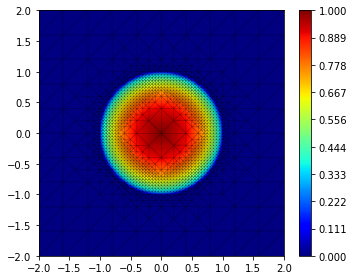

In [2]:
def test1(fileName):
    grid = view( cartesianDomain([-2,-2],[2,2],[10,10]) )

    @gridFunction(grid)
    def gf(x): return math.sqrt(1-(x[0]**2+x[1]**2)) if x[0]**2+x[1]**2<1 else 0

    space = lagrange(grid)
    df = space.interpolate(gf,name="test")

    grid.hierarchicalGrid.globalRefine(4)
    for i in range(5):
        grid.hierarchicalGrid.mark(lambda e:
             Marker.refine if df.localFunction(e).jacobian([1./3.,1./3.]).infinity_norm > 1
             else Marker.coarsen)
        adapt(grid.hierarchicalGrid)
        df.interpolate( gf )
    print("size of adapted grid:", grid.size(0))
    df.plot()

    checkPointer = CheckPointer(fileName, grid.hierarchicalGrid)
    checkPointer.add(df)
    checkPointer.backup()

test1("dump.pickle")

Now we restore the backup

size of restored grid: 4304


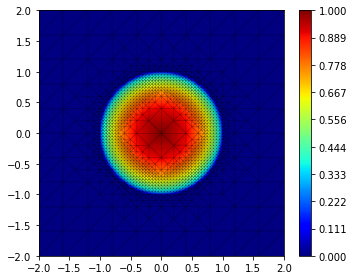

In [3]:
checkPointer = CheckPointer("dump.pickle")
grid = checkPointer.hierarchicalGrid().leafView
print("size of restored grid:", grid.size(0))
space = lagrange(grid)
df = space.interpolate([0],name="test")
checkPointer.add(df)
checkPointer.restore()
df.plot()